# KAIST 산학 교육 : Stable diffusion

![](https://github.com/EilieYoun/box/blob/main/images/240214_sd_intro.png?raw=true)

**참고 사이트**

- [허깅페이스 Diffusers](https://huggingface.co/docs/diffusers/index)
- [Diffusers 라이브러리](https://github.com/huggingface/diffusers)
- [High-Resolution Image Synthesis with Latent Diffusion Models
](https://arxiv.org/abs/2112.10752)

## 0. Setting
---

In [ ]:
!pip install --upgrade diffusers[torch]

In [2]:
from diffusers.utils import make_image_grid, load_image
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pprint import pprint as pp

def noise2image(noise):
    image = noise.permute(0,2,3,1).cpu().numpy()[0].copy()
    image =  np.clip( (image / 2 + 0.5) , 0, 1)
    image = Image.fromarray((image * 255).round().astype("uint8"))
    return image


## 1. DDPM
----

![](https://github.com/EilieYoun/box/blob/main/images/240214_ddpm.png?raw=true)

* `google/ddpm-bedroom-256` : https://huggingface.co/google/ddpm-bedroom-256

In [3]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained('google/ddpm-bedroom-256')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
ddpm

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "google/ddpm-bedroom-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

### **| Module**


#### **unet**


* 구성 확인

In [ ]:
unet = ddpm.unet.to('cuda') # unet 모듈
print(unet)

In [6]:
unet.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

In [ ]:
sample_size = unet.config.sample_size # unet의 인풋 size
channels = unet.config.in_channels # unt의 인풋 channels
image_shape = (1, channels, sample_size, sample_size) # image shape 정의
print('image_shape: ', image_shape)

image_shape:  (1, 3, 256, 256)


* 함수 작동

In [ ]:
x_t = torch.randn(image_shape, device='cuda') # x_t 정의
t = 900 # t 정의

with torch.no_grad(): # 가중치 계산 비활성화
    noisy_residual = unet(x_t, t).sample # unet 작동

print('t : ', t)
print('x_t : ', x_t.shape)
print('noisy residual : ', noisy_residual.shape)

t :  900
x_t :  torch.Size([1, 3, 256, 256])
noisy residual :  torch.Size([1, 3, 256, 256])


#### **scheduler**

* 구성 확인

In [ ]:
scheduler = ddpm.scheduler # noise scheduler 모듈
print(scheduler)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



In [ ]:
scheduler.set_timesteps(20) # noise scheduler timesteps 설정
print('timesteps : ', len(scheduler.timesteps), scheduler.timesteps) # timesteps 확인

timesteps :  20 tensor([950, 900, 850, 800, 750, 700, 650, 600, 550, 500, 450, 400, 350, 300,
        250, 200, 150, 100,  50,   0])


* 함수 작동

In [ ]:
x_t1 = scheduler.step(noisy_residual, t, x_t).prev_sample # noise scheduler 작동

print('t : ', t)
print('x_t : ', x_t.shape)
print('noisy residual : ', noisy_residual.shape)
print('x_(t-1) : ', x_t1.shape)

t :  900
x_t :  torch.Size([1, 3, 256, 256])
noisy residual :  torch.Size([1, 3, 256, 256])
x_(t-1) :  torch.Size([1, 3, 256, 256])


* noise 확인

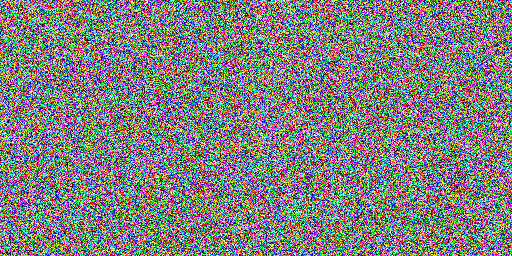

In [ ]:
xt_image = noise2image(x_t) # x_t 이미지 변경
xt1_image = noise2image(x_t1) # x_t1 이미지 변경
make_image_grid([xt_image, xt1_image], rows=1, cols=2)

### **| Inference**



#### **make loop code**


In [ ]:
x_list = [] # 이미지 담을 리스트 생성

x_t =  torch.randn(image_shape, device='cuda') # 초기 x_t 설정
for t in scheduler.timesteps: # timesteps 만큼 반복하기
    with torch.no_grad(): # 가중치 계산 비활성화
        noisy_residual = unet(x_t, t).sample # unet 작동
        x_t1  = scheduler.step(noisy_residual, t, x_t).prev_sample # noise scheduler 작동
        x_t = x_t1 # x_t 업데이트

    x_image = noise2image(x_t) # image 변경
    x_list.append(x_image) # 이미지 리스트에 담기

In [ ]:
make_image_grid(x_list, rows=2, cols=10)

Output hidden; open in https://colab.research.google.com to view.

#### **Use pipeline**


- [`class diffusers.DDPMPipeline`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddpm/pipeline_ddpm.py)


- [Parameters](https://huggingface.co/docs/diffusers/v0.26.1/en/api/pipelines/ddpm#diffusers.DDPMPipeline)


  0%|          | 0/20 [00:00<?, ?it/s]

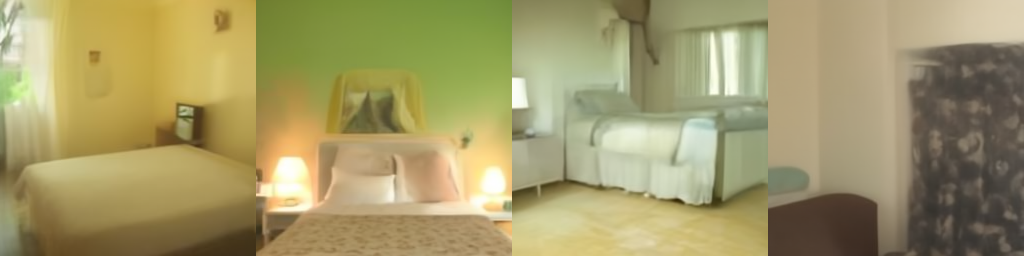

In [ ]:
imgs = ddpm(num_inference_steps=20, batch_size=4)[0]
make_image_grid(imgs, rows=1, cols=len(imgs))

## 2. Stable Diffusion : text-to-image
---

![](https://github.com/EilieYoun/box/blob/main/images/240214_sd_text2img.png?raw=true)

- `runwayml/stable-diffusion-v1-5`
- `dreamlike-art/dreamlike-photoreal-2.0`
- `stabilityai/stable-diffusion-xl-base-1.0`
- `stabilityai/sdxl-turbo`

In [ ]:
from diffusers import AutoPipelineForText2Image

sd = AutoPipelineForText2Image.from_pretrained('runwayml/stable-diffusion-v1-5', torch_dtype=torch.float16).to('cuda')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
sd.config

FrozenDict([('vae', ('diffusers', 'AutoencoderKL')),
            ('text_encoder', ('transformers', 'CLIPTextModel')),
            ('tokenizer', ('transformers', 'CLIPTokenizer')),
            ('unet', ('diffusers', 'UNet2DConditionModel')),
            ('scheduler', ('diffusers', 'PNDMScheduler')),
            ('safety_checker',
             ('stable_diffusion', 'StableDiffusionSafetyChecker')),
            ('feature_extractor', ('transformers', 'CLIPImageProcessor')),
            ('image_encoder', (None, None)),
            ('requires_safety_checker', True),
            ('_name_or_path', 'runwayml/stable-diffusion-v1-5')])

### **| Module**


#### **tokenizer**

In [ ]:
prompt = '' # 프롬프트 작성

# tokenizer 작동
token = sd.tokenizer(prompt,
                     padding="max_length",
                     max_length=sd.tokenizer.model_max_length,
                     truncation=True,
                     return_tensors="pt",
                    )

print('prompt: ' , prompt)
print('token: ', token)

prompt:  
token:  {'input_ids': tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}


#### **text_encoder**

In [ ]:
# text encoer 확인
print(sd.text_encoder)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [ ]:
# text encoder 작동
prompt_embed = sd.text_encoder(token.input_ids.to('cuda'), attention_mask = token.attention_mask.to('cuda'), output_hidden_states=True)[0]
print(prompt_embed.shape, prompt_embed.dtype)

torch.Size([1, 77, 768]) torch.float16


#### **unet**

#### **unet**


* 구성 확인

In [ ]:
unet = sd.unet.to('cuda') # unet 모듈
#print(unet)

In [ ]:
sample_size = unet.config.sample_size # unet의 인풋 size
channels = unet.config.in_channels # unt의 인풋 channels
latent_shape = (1, channels, sample_size, sample_size) # image shape 정의
print('latent_shape: ', latent_shape)

latent_shape:  (1, 4, 64, 64)


* 함수 작동

In [ ]:
x_t = torch.randn(latent_shape, device='cuda', dtype=torch.float16) # x_t 정의
t = 900 # t 정의

with torch.no_grad(): # 가중치 계산 비활성화
    noisy_residual = unet(x_t, t, prompt_embed).sample # unet 작동

print('t : ', t)
print('x_t : ', x_t.shape)
print('prmpte_embed: ', prompt_embed.shape)
print('noisy residual : ', noisy_residual.shape)

t :  900
x_t :  torch.Size([1, 4, 64, 64])
prmpte_embed:  torch.Size([1, 77, 768])
noisy residual :  torch.Size([1, 4, 64, 64])


#### **scheduler**

* 구성 확인

In [ ]:
scheduler = sd.scheduler # noise scheduler 모듈
print(scheduler)

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.26.3",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}



* 함수 작동

In [ ]:
x_t1 = scheduler.step(noisy_residual, t, x_t).prev_sample # noise scheduler 작동

print('t : ', t)
print('x_t : ', x_t.shape)
print('noisy residual : ', noisy_residual.shape)
print('x_(t-1) : ', x_t1.shape)

t :  900
x_t :  torch.Size([1, 4, 64, 64])
noisy residual :  torch.Size([1, 4, 64, 64])
x_(t-1) :  torch.Size([1, 4, 64, 64])


#### **vae**

torch.Size([1, 4, 64, 64]) torch.Size([1, 3, 512, 512])


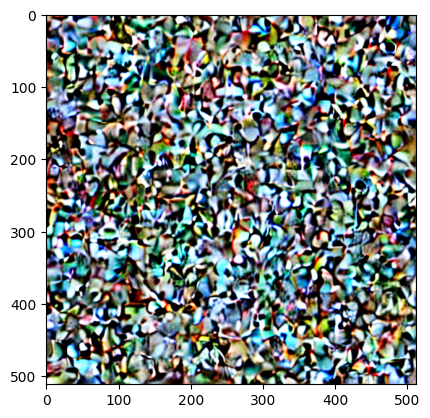

In [ ]:
latent = x_t1 / sd.vae.config.scaling_factor # latent 조정
with torch.no_grad(): # 가중치 계산 비활성화
    image = sd.vae.decode(latent, return_dict=False)[0] # vae decoder 작동

print('latent: ', latent.shape)
print('image: ', image.shape)

image = noise2image(image) # image 변환
_=plt.imshow(image) # image 확인

### **| Inference**



#### **Use pipeline**


- [`class diffusers.StableDiffusionPipieline`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py)

- [Parameters](https://huggingface.co/docs/diffusers/v0.26.1/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline)
  * `prompt (str or List[str], optional)` — The prompt or prompts to guide image generation. If not defined, you need to pass prompt_embeds.

  * `height (int, optional, defaults to self.unet.config.sample_size * self.vae_scale_factor)` — The height in pixels of the generated image.

  * `width (int, optional, defaults to self.unet.config.sample_size * self.vae_scale_factor)` — The width in pixels of the generated image.

  * `num_inference_steps (int, optional, defaults to 50)` — The number of denoising steps. More denoising steps usually lead to a higher quality image at the expense of slower inference.

  * `timesteps (List[int], optional)` — Custom timesteps to use for the denoising process with schedulers which support a timesteps argument in their set_timesteps method. If not defined, the default behavior when
 num_inference_steps is passed will be used. Must be in descending order.

  * `guidance_scale (float, optional, defaults to 7.5)` — A higher guidance scale value encourages the model to generate images closely linked to the text prompt at the expense of lower image quality. Guidance scale is enabled when guidance_scale > 1.

  * `negative_prompt (str or List[str], optional)` — The prompt or prompts to guide what to not include in image generation. If not defined, you need to pass negative_prompt_embeds instead. Ignored when not using guidance (guidance_scale < 1).

  * `num_images_per_prompt (int, optional, defaults to 1)` — The number of images to generate per prompt.
```

In [ ]:
prompt1 = "An astronaut in the jungle, cold color palette, muted colors, detailed, 8k, masterpiece, wonderful artistic"
prompt2 = "An astronaut riding a horse on marse, cold color palette, muted colors, detailed, 8k, masterpiece, wonderful artistic"

num_inference_steps = 25
num_images_per_prompt = 4

imgs = sd([prompt1, prompt2],
        num_inference_steps=num_inference_steps,
        num_images_per_prompt=num_images_per_prompt,
        generator = torch.Generator(device="cuda").manual_seed(4),
        )[0]

make_image_grid(imgs, rows=2, cols=num_images_per_prompt)

Output hidden; open in https://colab.research.google.com to view.

## Stable Diffusion: Beyond the "Text-to-Image""
---

![](https://github.com/EilieYoun/box/blob/main/images/240214_sd_beyond.png?raw=true)

- controlnet : https://huggingface.co/docs/diffusers/api/pipelines/controlnet
- image-to-image : https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/img2img
- inpainting : https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/inpaint
- stable diffusion XL : https://huggingface.co/docs/diffusers/using-diffusers/sdxl
- SDXL Turbo : https://huggingface.co/docs/diffusers/using-diffusers/sdxl_turbo
- LoRA : https://huggingface.co/docs/diffusers/training/lora

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
pipe

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

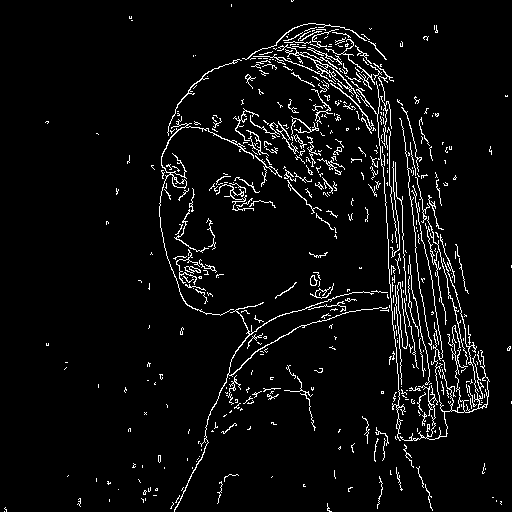

In [ ]:
import cv2
from PIL import Image

# download an image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(image)

# get canny image
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image

  0%|          | 0/20 [00:00<?, ?it/s]

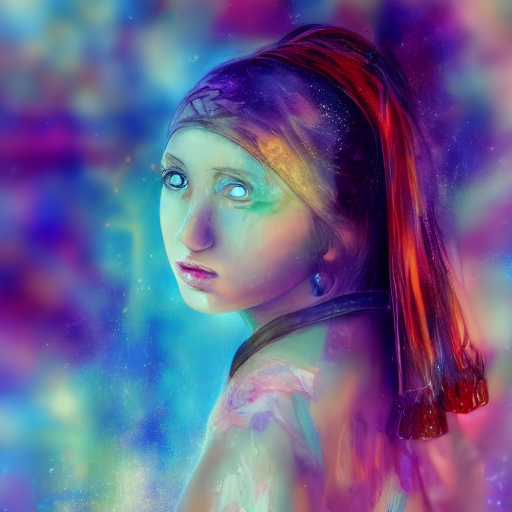

In [ ]:
generator = torch.manual_seed(0)
image = pipe(
    "Art, artistic, fairytail, A girl, warm color, masterpiece, detailed face, 8k, water color", num_inference_steps=20, generator=generator, image=canny_image
).images[0]
image